In [1]:
import numpy as np
import torch as tc
import numpy.random as rd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import argparse

from circuit_solver import circuit as ct
from circuit_solver import elements as es
from circuit_solver import utils
from circuit_solver.learning import CoupledLearning, CLTrainingConfig, CLTestingConfig

# The fix

We need to make edge ordering agree between adjacency and theta.

Also, when initializing the model, the `MaskedNonlinearity`s need to know which edges to mask, and they use the `element_dict` ordering currently. 

**Options**
1. One option is to sort the element_dict edge list upon creating the circuit to make it match the adjacency matrix

2. Another option is to change the adjacency matrix when creating circuit to make it match the element_dict lists

3. Yet another option is to allow them to disagree but change the edge updates. This feels more dangerous, because then we have two edge orderings floating around.

I like option 1. Option 2 would make it so new adjacency matrices generated would disagree. Option 3 would make things more dangerous and would require changes both in the updates, and in the `MaskedNonlinearity`

Is there a reason to want a special edge ordering to matter?


In [2]:
# Data params
P = 10000
c = 1         # Normalized correlation between x and y
s = 1/4        # Square root of y variance

# element params
# def generate_element():
element_kwargs = {
    'init_mode':'constant',
    'init_params':1.
}
element_generator = es.Resistor

# training_config
batch_size = 10
N_batches = 200
alpha = 1E-3
eta = 1E-2

model_config = ct.CircuitModelConfig()

training_config = CLTrainingConfig(
    batch_size=batch_size,
    N_batches=N_batches,
    alpha=alpha,
    eta=eta,
)

### Generate data

In [3]:
cov_matrix = np.array([[1, s * c],
                    [s * c, s**2]])
# Generate samples
Z = np.random.multivariate_normal([0, 0], cov_matrix, size=P)
# X = np.stack((x[:,0], -x[:,0]), axis=1)
X = Z[:,0][:,None]
Y = Z[:,1][:,None]


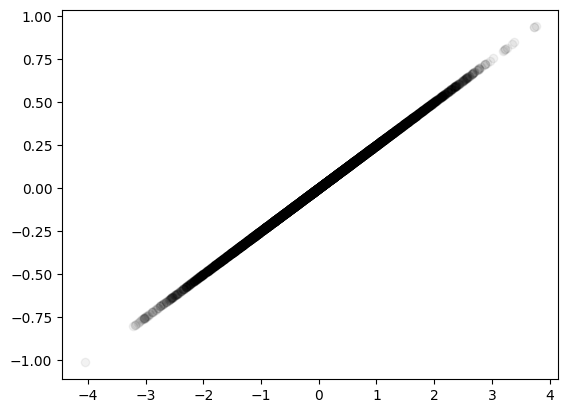

In [4]:
plt.plot(X[:,0], Y[:,0], 'ok', alpha=0.05)

### Build model

In [5]:
# define indices for different node types
x_inds = [0]
y_inds = [1]
GROUND = [2]
all_nodes = [0, 1, 2]

node_type_dict = {
    'GROUND': GROUND,
    'HIGH':[],
    'LOW':[],
    'x': x_inds,
    'y': y_inds,
}

# define edges
all_edges_bad = [(1,2), (0,1)]
all_edges_good = [(0,1), (1,2)]

# the good graph
graph_good = nx.Graph()
graph_good.add_nodes_from(all_nodes)
graph_good.add_edges_from(all_edges_good)

# the bad graph
graph_bad = nx.Graph()
graph_bad.add_nodes_from(all_nodes)
graph_bad.add_edges_from(all_edges_bad)

# initialize Circuits
element_good = element_generator(**element_kwargs)
element_dict_good = {
    element_good: all_edges_good,
}
circuit_good = ct.Circuit(graph_good, element_dict_good)

element_bad = element_generator(**element_kwargs)
element_dict_bad = {
    element_bad: all_edges_bad,
}
circuit_bad = ct.Circuit(graph_bad, element_dict_bad)

In [6]:
model_bad = ct.CircuitModel(circuit_bad, node_type_dict, model_config)
history_bad = CoupledLearning(X, Y, model_bad, training_config)

model_good = ct.CircuitModel(circuit_good, node_type_dict, model_config)
history_good = CoupledLearning(X, Y, model_good, training_config)

100%|██████████| 200/200 [00:00<00:00, 762.94it/s]


In [7]:
def plot_history(history):
    k1 = history['Resistor'][0][:,0]
    k2 = history['Resistor'][0][:,1]
    def a(k1, k2):
        return k1 / (k1 + k2)
    a_opt = s
    fig, ax = plt.subplots(ncols=2, figsize=[10, 5])
    ax[0].plot(k1, color='r', alpha=0.5)
    ax[0].plot(k2, color='b', alpha=0.5)
    ax[1].plot(a(k1, k2), color='k')
    ax[1].axhline(a_opt, linestyle='--', color='grey')
    return fig, ax

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

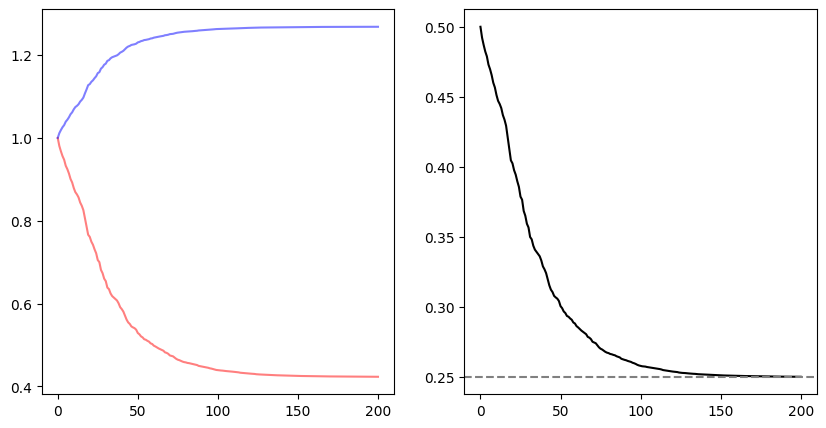

In [8]:
plot_history(history_good)

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

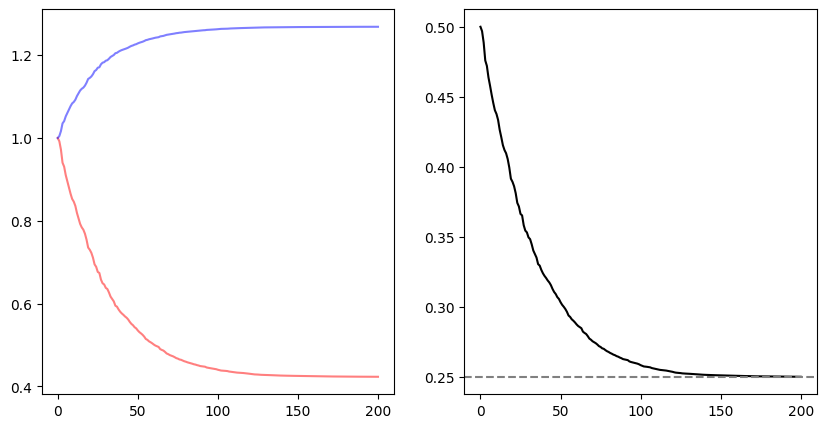

In [9]:
plot_history(history_bad)

### The problem

There are two inconsistent edge orderings. One is set by the graph incidence matrix, the other is set by the order of the edge list used to build the circuit.

`model.element_to_edge_inds` is what is used to assign parameter updates.

In [10]:
model_bad.Del, model_good.Del

(tensor([[-1.,  1.,  0.],
         [ 0., -1.,  1.]]),
 tensor([[-1.,  1.,  0.],
         [ 0., -1.,  1.]]))

In [11]:
model_good.element_to_edge_inds['Resistor'], model_bad.element_to_edge_inds['Resistor']

([0, 1], [0, 1])

# Reproduce bug (won't work after fix)

In [ ]:
# Data params
P = 10000
c = 1         # Normalized correlation between x and y
s = 1/4        # Square root of y variance

# element params
# def generate_element():
element_kwargs = {
    'init_mode':'constant',
    'init_params':1.
}
element_generator = es.Resistor

# training_config
batch_size = 10
N_batches = 200
alpha = 1E-3
eta = 1E-2

model_config = ct.CircuitModelConfig()

training_config = CLTrainingConfig(
    batch_size=batch_size,
    N_batches=N_batches,
    alpha=alpha,
    eta=eta,
)

### Generate data

In [ ]:
cov_matrix = np.array([[1, s * c],
                    [s * c, s**2]])
# Generate samples
Z = np.random.multivariate_normal([0, 0], cov_matrix, size=P)
# X = np.stack((x[:,0], -x[:,0]), axis=1)
X = Z[:,0][:,None]
Y = Z[:,1][:,None]


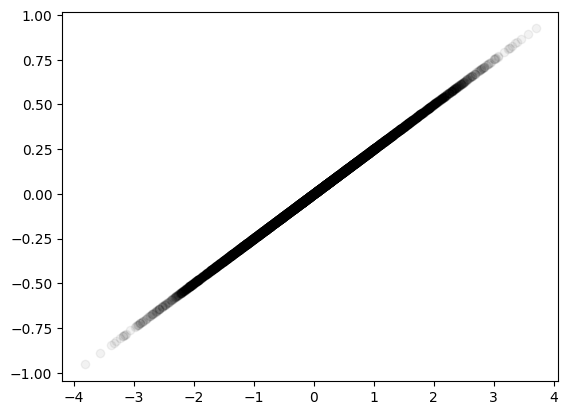

In [ ]:
plt.plot(X[:,0], Y[:,0], 'ok', alpha=0.05)

### Build model

In [ ]:
# define indices for different node types
x_inds = [0]
y_inds = [1]
GROUND = [2]
all_nodes = [0, 1, 2]

node_type_dict = {
    'GROUND': GROUND,
    'HIGH':[],
    'LOW':[],
    'x': x_inds,
    'y': y_inds,
}

# define edges
all_edges_bad = [(1,2), (0,1)]
all_edges_good = [(0,1), (1,2)]

# the good graph
graph_good = nx.Graph()
graph_good.add_nodes_from(all_nodes)
graph_good.add_edges_from(all_edges_good)

# the bad graph
graph_bad = nx.Graph()
graph_bad.add_nodes_from(all_nodes)
graph_bad.add_edges_from(all_edges_bad)

# initialize Circuits
element_good = element_generator(**element_kwargs)
element_dict_good = {
    element_good: all_edges_good,
}
circuit_good = ct.Circuit(graph_good, element_dict_good)

element_bad = element_generator(**element_kwargs)
element_dict_bad = {
    element_bad: all_edges_bad,
}
circuit_bad = ct.Circuit(graph_bad, element_dict_bad)

In [ ]:
model_bad = ct.CircuitModel(circuit_bad, node_type_dict, model_config)
history_bad = CoupledLearning(X, Y, model_bad, training_config)

model_good = ct.CircuitModel(circuit_good, node_type_dict, model_config)
history_good = CoupledLearning(X, Y, model_good, training_config)

100%|██████████| 200/200 [00:00<00:00, 765.06it/s]


In [ ]:
def plot_history(history):
    k1 = history['Resistor'][0][:,1]
    k2 = history['Resistor'][0][:,0]
    def a(k1, k2):
        return k1 / (k1 + k2)
    a_opt = s
    fig, ax = plt.subplots(ncols=2, figsize=[10, 5])
    ax[0].plot(k1, color='r', alpha=0.5)
    ax[0].plot(k2, color='b', alpha=0.5)
    ax[1].plot(a(k1, k2), color='k')
    ax[1].axhline(a_opt, linestyle='--', color='grey')
    return fig, ax

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

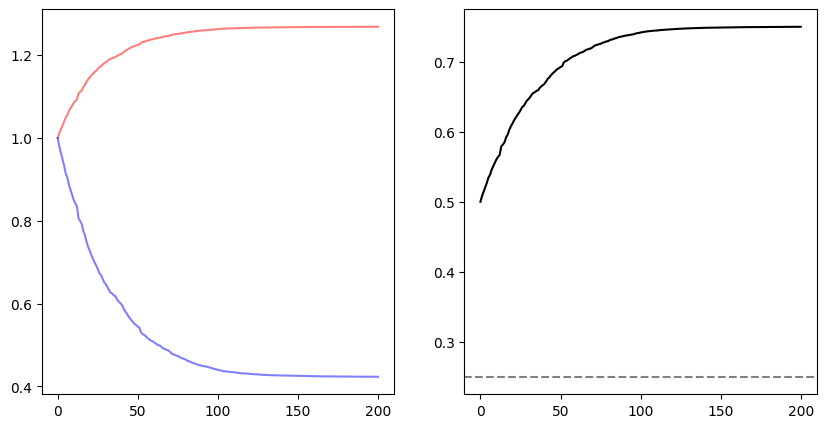

In [ ]:
plot_history(history_good)

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

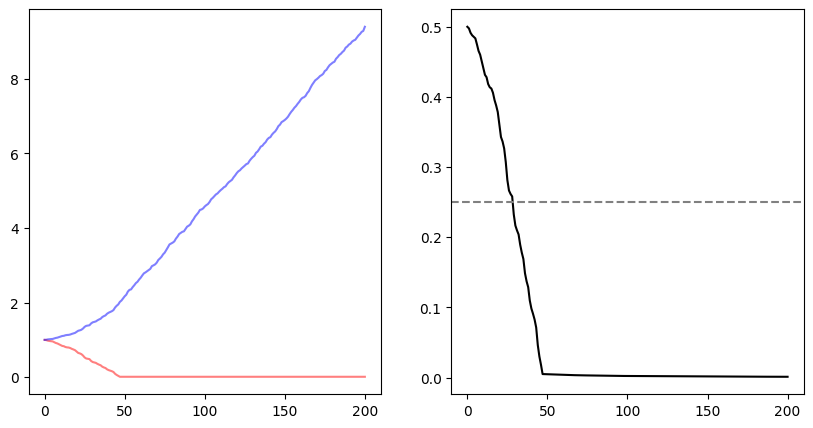

In [ ]:
plot_history(history_bad)

### The problem

There are two inconsistent edge orderings. One is set by the graph incidence matrix, the other is set by the order of the edge list used to build the circuit.

`model.element_to_edge_inds` is what is used to assign parameter updates.

In [ ]:
model_bad.Del, model_good.Del

(tensor([[-1.,  1.,  0.],
         [ 0., -1.,  1.]]),
 tensor([[-1.,  1.,  0.],
         [ 0., -1.,  1.]]))

In [ ]:
model_good.element_to_edge_inds['Resistor'], model_bad.element_to_edge_inds['Resistor']

([0, 1], [1, 0])